# Homework 4
# Costa Rica Poverty Classification

## Purpose: 
In this notebook, I am going to go through the preprocessing steps required to prepare this data for a model. This includes both imputing missing values and feature engineering new features that can help the predicition process. The I will put the data through several models and select several to tune to get a better score. Then I will focus on different applications for the model. I will explore how changing certain parameters can help a model focus on increasing the recall of certain classes. I will discuss different metrics to measure a model by and how different types of models can help ensure that we are answering the questions we want to answer with our data.

### Credit:
Data : [Kaggle - Costa Rican Household Poverty Level Prediction](https://www.kaggle.com/c/costa-rican-household-poverty-prediction)

## Table of Contents
1. [Read in Data](#read)  
2. [Clean Data](#clean)  
    2.1 [Understanding Missing Values](#misviz)  
    2.2 [Impute Missing Values](#impute)  
    2.3 [Categorical Variables](#catvar)  
3. [Feature Engineering](#feat)  
4. [Visualization and Exploration](#viz)  
    4.1 [Target Variable](#viztarget)  
    4.2 [Predictor Variables](#vizvars)  
5. [Modeling](#model)  
    5.1 [Cross-Validation Scores](#crossval)  
    5.2 [Random Search](#rand)  
    5.3 [Classification Reports & Confusion Matrices](#cm)  
6. [Handling Unbalanced Data](#imbdata)  
    6.1 [Random Forest with Weights](#weights)  
    6.2 [Oversampling](#smote)  
7. [Understanding & Interpreting the Model](#featimport)

## 1. Read in Data
<a id="read"></a>

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
sns.set_palette(sns.color_palette('hls', 7))

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

#Models
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline, make_pipeline

#Validation
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, classification_report, confusion_matrix

#Undersampling
from imblearn.over_sampling import RandomOverSampler

In [5]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
y = train.loc[(train['parentesco1']==1), 'Target']
Id = test.Id

In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


So it looks like we have a lot of integers, a few floats, and a few objects

In [7]:
ntrain = train.shape[0]
data = pd.concat((train.drop('Target', axis = 1), test)).reset_index(drop = True)
data = data.drop('Id', axis = 1)

In [8]:
data.shape

(33413, 141)

## 2. Clean Data
<a id="clean"></a>

## 2.1 Understand Missing Values
<a id="misviz"></a>

Text(0.5, 1.0, 'Percent missing data by feature')

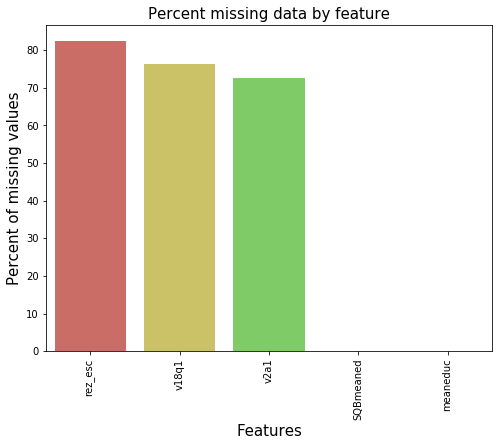

In [9]:
#Check to see missing values
#data.isna().sum().sort_values(ascending = False)[:35]
data_na = (data.isnull().sum() / len(data)) * 100
data_na = data_na.drop(data_na[data_na == 0].index).sort_values(ascending=False)[:30]
f, ax = plt.subplots(figsize=(8, 6))
plt.xticks(rotation='90')
sns.barplot(x=data_na.index, y = data_na)
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

It looks like we only have 5 features with missing values. These features are defined in the data description as follows:

**rez_esc** - Years behind in school:
The Kaggle Discussions give us some insights that this is only defined for children in school. Thus we will assume anyone ages 18+ should not have a value here.

**v18q1** - Number of tablets household owns:
This value is missing if the number of tablets owned by the household is equal to zero. So we will replace all of these missing values with zero.

**v2a1** - Monthly rent payment:
There is no clear answer to why these are missing. We will have to look at the data to see if we can find something.

**SQBmeaned** - Square of the mean years of education of adults (>=18) in the household

**meaneduc** - Average years of education for adults (18+):

We see for both of these education related values we are missing the same number of values. So for these, we will explore the data and see if there is some other variable that explains these.

## 2.2 Impute Missing Values
<a id="impute"></a>

In [10]:
# The easy one. Number of tablets
data.v18q1 = data.v18q1.fillna(0)

In [11]:
#To understand rent we are going to look at other variables that go along with it.
#For example, we are going to look at home ownership
ownership = ['tipovivi1', 'tipovivi2', 'tipovivi3', 'tipovivi4', 'tipovivi5']
ownership_data = data.loc[data['v2a1'].isnull(), ownership].sum()
ownership_data = ownership_data.reset_index()

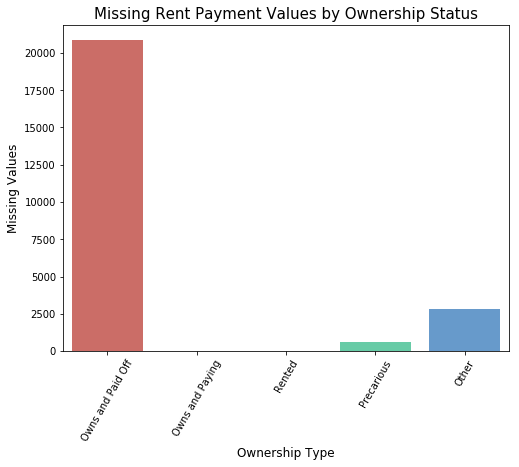

In [12]:
f, ax = plt.subplots(figsize=(8, 6))
plot = sns.barplot(x = 'index', y = 0 , data = ownership_data)
plt.xlabel('Ownership Type', fontsize=12)
plt.ylabel('Missing Values', fontsize=12)
plt.title('Missing Rent Payment Values by Ownership Status', fontsize=15)
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.show()

In [13]:
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

#Flag any missing observations we don't understand
data['missing_rent'] = 0
data.loc[(data.tipovivi1.isnull()), 'missing_rent'] = 1

#Fill in remaining missing values with median only using training data from head of households
data['v2a1'] = data.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

In [14]:
pd.options.display.max_columns = 150
data.loc[(data['SQBmeaned'].isnull()) & (data['meaneduc'].isnull())]

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,missing_rent
1291,0.0,0,7,0,1,1,0,0.0,0,0,0,0,1,1,0,1,1,1,1,10,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1b31fd159,1,0,0,1,8,no,10,NaN,0,0,0,1,0,0,0,0,0,5,0.200000,1,0,0,0,0,1,1,1,1,1,0,0,0,0,0,1,0,18,100,324,1,0,1,0.040000,64.0,NaN,324,0
1840,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,6,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8,4,no,NaN,0,0,1,0,0,0,0,0,0,1,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,36,324,4,16,4,4.000000,64.0,NaN,324,0
1841,110000.0,0,1,0,1,1,0,0.0,0,1,1,0,1,1,0,2,2,2,2,4,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,a874b7ce7,2,0,0,2,8,4,no,NaN,0,1,0,0,0,0,0,0,0,1,2.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,18,16,324,4,16,4,4.000000,64.0,NaN,324,0
2049,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,faaebf71a,2,0,0,2,8,12,no,NaN,0,0,0,0,0,0,1,0,0,2,1.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.000000,64.0,NaN,361,0
2050,180000.0,0,3,0,1,1,0,0.0,0,2,2,0,0,0,0,2,2,2,2,12,NaN,2,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,faaebf71a,2,0,0,2,8,12,no,NaN,0,0,0,0,0,0,1,0,0,2,1.000000,0,0,1,0,0,0,0,1,2,1,0,0,0,0,0,1,0,19,144,361,4,144,4,1.000000,64.0,NaN,361,0
9561,175000.0,0,4,0,1,1,1,1.0,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1e2fc704e,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,2,0.500000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,18,121,324,1,0,1,0.250000,64.0,NaN,324,0
10092,399378.0,0,6,0,1,0,1,3.0,0,0,0,0,1,1,0,1,1,1,4,11,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,bb7038e41,1,0,0,1,8,no,11,NaN,0,0,0,0,1,0,0,0,0,4,1.000000,0,0,1,0,0,0,1,1,4,1,0,0,0,0,0,1,0,18,121,324,1,0,1,1.000000,64.0,NaN,324,0
10093,180000.0,0,4,0,1,1,0,0.0,0,0,0,0,2,2,0,2,2,2,2,12,NaN,2,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,4937daf94,2,0,0,2,8,no,12,NaN,0,0,0,0,0,0,0,1,

There doesnt seem to be anything obvious about why these values are missing, so we are going to impute them. We will do this by grouping by years of schooling and filling missing values with the median. This seems reasonable since the years of schooling of a single person and the mean years of schooling in their household have some relationship.

Once again we will make sure we are imputing only using the median of the training data in order to not have any data leakage.

In [15]:
data['meaneduc'] = data.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))
data['SQBmeaned'] = (data.meaneduc)**2

In [17]:
#We assume anyone not between the age of 7 and 17 is not in school and thus this doesnt apply to them.
data.loc[((data['age'] >= 18) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

#For those in school we flag them as missing values.
data['missing_rez_esc'] = 0
data.loc[(data.rez_esc.isnull()), 'missing_rez_esc'] = 1

#Now we are going to impute the rest of our missing values after grouping them by age and years in school
#This should give us a good idea of if they should be years behind.
data['rez_esc'] = data.groupby('age')['rez_esc'].transform(lambda x: x.fillna(x.median()))

## 2.3 Categorical Variables
<a id="catvar"></a>

In [16]:
data.select_dtypes(include = 'object').head()

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no


idhogar is fine, we will fix he other three. For edjefe and edjefa, no means 0 and yes means 1. Seems like when collecting the data some people were collecting binary variables and some were collecting numeric.

In [18]:
cat_cols = ['dependency', 'edjefe', 'edjefa']
for col in cat_cols:
    data.loc[(data[col] == 'yes'), col]=1
    data.loc[(data[col] == 'no'), col]=0
data[cat_cols] = data[cat_cols].apply(pd.to_numeric)

## 3. Feature Engineering
<a id="feat"></a>

In [19]:
data['child_per'] = data['hogar_nin'] / data['hogar_total']
data['old_per'] = data['hogar_mayor'] / data['hogar_total']
data['tech_score'] = (data['v18q'] + data['abastaguadentro'] + data['public'] + data['planpri'] + data['coopele']
                      + data['energcocinar2'] + data['energcocinar3'] + data['computer'] + data['mobilephone']
                      + data['television'])
data['home_quality'] = (data['cielorazo'] + data['epared2'] + 2*data['epared3'] + data['etecho2'] + 2*data['etecho3']
                        + data['eviv2'] + 2*data['eviv3'])


## 4. Visualizations
<a id="viz"></a>

In [21]:
train = data[:ntrain]
x = train.loc[train['parentesco1']==1].drop('idhogar', axis = 1)
train = pd.concat([x, y], axis = 1)
test = data[ntrain:].drop('idhogar', axis = 1)
train.shape

(2973, 147)

## 4.1 Target Variable
<a id="viztarget"></a>

Text(0.5, 1.0, 'Variables Correlated With Poverty Level')

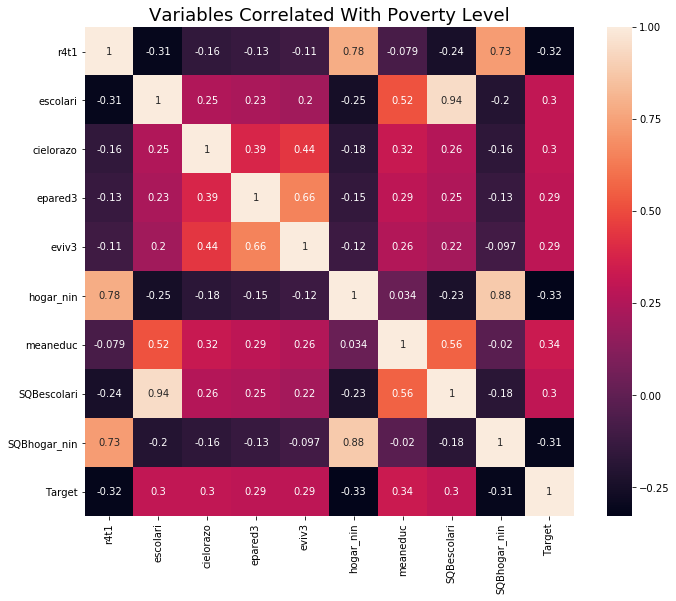

In [20]:
#Take a look at the variables that are most highly correlated with Poverty Score
corr_train = train.corr()
highest_corr = corr_train.index[abs(corr_train["Target"])>0.29]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train[highest_corr].corr(), square = True, annot = True)
plt.title('Variables Correlated With Poverty Level', fontsize=18)

([<matplotlib.axis.XTick at 0x1f407804978>,
 <a list of 4 Text xticklabel objects>)

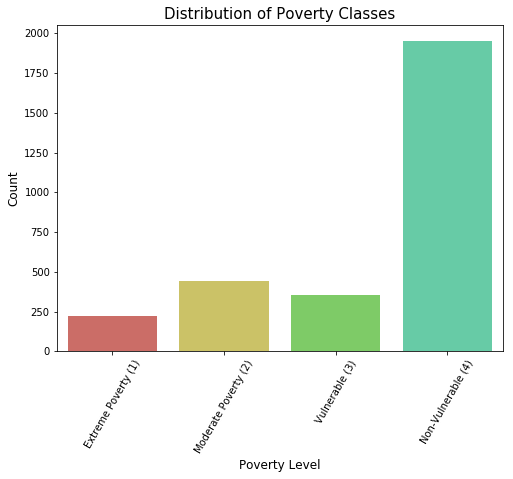

In [22]:
#See the distribution of poverty scores
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(train.Target)
plt.title('Distribution of Poverty Classes', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)

## 4.2 Predictor Variables
<a id="vizvars"></a>

Text(0, 0.5, 'Average Poverty Level')

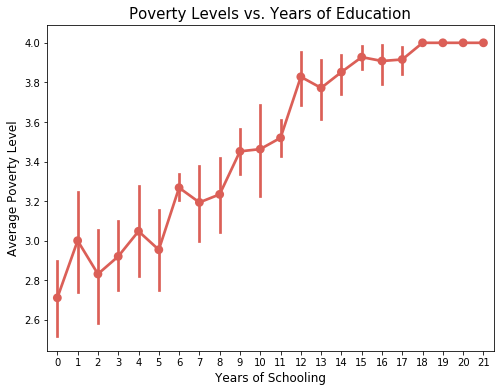

In [23]:
f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x = train['escolari'], y = train.Target)
plt.title('Poverty Levels vs. Years of Education', fontsize=15)
plt.xlabel('Years of Schooling', fontsize=12)
plt.ylabel('Average Poverty Level', fontsize=12)

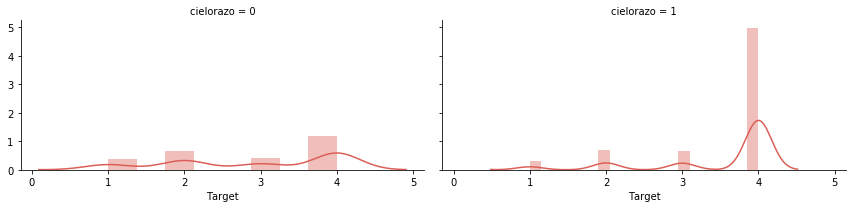

In [24]:
plot = sns.FacetGrid(data = train, col ='cielorazo', aspect=2, margin_titles = True)
plot.map(sns.distplot, 'Target')

Text(0, 0.5, 'Average Household Education')

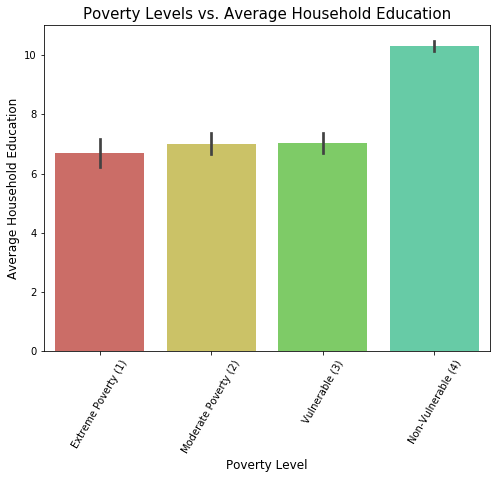

In [25]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x = 'Target', y = 'meaneduc', data = train)
plt.title('Poverty Levels vs. Average Household Education', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)
plt.ylabel('Average Household Education', fontsize=12)

Text(0, 0.5, 'Average Poverty Level')

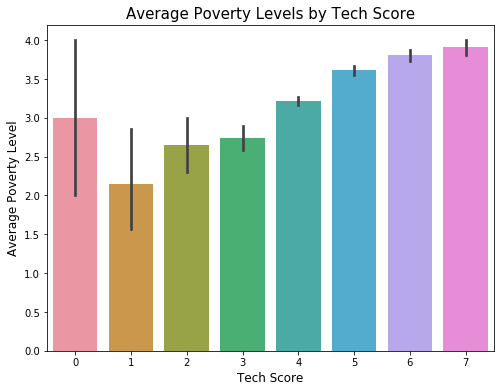

In [26]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x = 'tech_score', y = 'Target', data = train)
plt.title('Average Poverty Levels by Tech Score', fontsize=15)
plt.xlabel('Tech Score', fontsize=12)
plt.ylabel('Average Poverty Level', fontsize=12)

In [ ]:
f, ax = plt.subplots(figsize=(8, 6))
sns.barplot(x = 'home_quality', y = 'Target', data = train)
plt.title('Average Poverty Levels by Home Quality', fontsize=15)
plt.xlabel('Home Quality', fontsize=12)
plt.ylabel('Average Poverty Level', fontsize=12)

## 5. Modeling
<a id="model"></a>

In [34]:
#Get a split
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [35]:
def test_clf(clf):
    score = cross_val_score(clf, x, y, scoring = 'f1_macro', cv = 5)
    print(clf.__class__.__name__,"Score =", score.mean())

## 5.1 Cross-Validation Scores
<a id="crossval"></a>

In [36]:
rf = RandomForestClassifier()
lgb = LGBMClassifier()
knn = KNeighborsClassifier()
svc = SVC()
gnb = GaussianNB()

models = [rf, lgb, knn, svc, gnb]
for clf in models:
    test_clf(clf)

RandomForestClassifier Score = 0.34931240683855386
LGBMClassifier Score = 0.266994226778726
KNeighborsClassifier Score = 0.31170305441515656
SVC Score = 0.19963169842530937
GaussianNB Score = 0.35256980756141637


We are just going to keep the Random Forest and Gaussian NB

## 5.2 Random Search
<a id="rand"></a>

In [37]:
#A little hyperparameter tuning
params = {'rf' : {'n_estimators' : np.arange(100,2000,100),
                  'criterion' : ['gini', 'entropy'],
                  'min_samples_split' : np.arange(2, 5, 1),
                  'max_features' : np.arange(10, 50, 10),
                  'max_depth' : np.arange(3, 10, 1)}
         }

In [38]:
def tune_params(clf, params):
    clf_rs = RandomizedSearchCV(clf, param_distributions = params, n_iter = 20, scoring = 'f1_macro')
    clf_rs.fit(x_train, y_train)
    clf_rs_pred = clf_rs.predict(x_test)
    score = f1_score(y_test, clf_rs_pred, average = 'macro')
    print('F1 Score: %s \n' %(score))
    print('Best Parameters:',clf_rs.best_params_)

In [201]:
rf = tune_params(rf, params['rf'])

F1 Score: 0.3466483247737833 

Best Parameters: {'n_estimators': 1600, 'min_samples_split': 4, 'max_features': 30, 'max_depth': 9, 'criterion': 'gini'}


In [39]:
rf = RandomForestClassifier(n_estimators = 1600, min_samples_split = 4, max_features = 30, max_depth = 9, criterion = 'gini')

## 5.3 Classification Reports & Confusion Matrices
<a id="cm"></a>

In [40]:
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    f, ax = plt.subplots(figsize=(8, 6))
    sns.heatmap(cm, annot=True)
    plt.title('Confusion Matrix', fontsize=15)
    plt.ylabel('True label', fontsize=12)
    plt.xlabel('Predicted label', fontsize=12)
    plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)
    plt.yticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)

In [41]:
rf.fit(x_train, y_train)
rf_pred = rf.predict(x_test)
gnb.fit(x_train, y_train)
gnb_pred = gnb.predict(x_test)

In [42]:
rf_report = classification_report(y_test, rf_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.64      0.10      0.18        69
           2       0.37      0.28      0.32       107
           3       0.21      0.03      0.06        90
           4       0.72      0.96      0.82       478

   micro avg       0.67      0.67      0.67       744
   macro avg       0.48      0.34      0.34       744
weighted avg       0.60      0.67      0.60       744



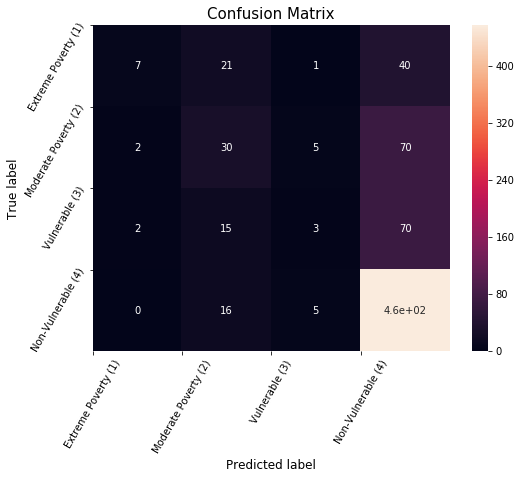

In [43]:
plot_confusion_matrix(y_test, rf_pred)

In [44]:
gnb_report = classification_report(y_test, gnb_pred)
print(gnb_report)

              precision    recall  f1-score   support

           1       0.36      0.26      0.30        69
           2       0.21      0.49      0.29       107
           3       0.17      0.21      0.19        90
           4       0.85      0.60      0.70       478

   micro avg       0.50      0.50      0.50       744
   macro avg       0.40      0.39      0.37       744
weighted avg       0.63      0.50      0.55       744



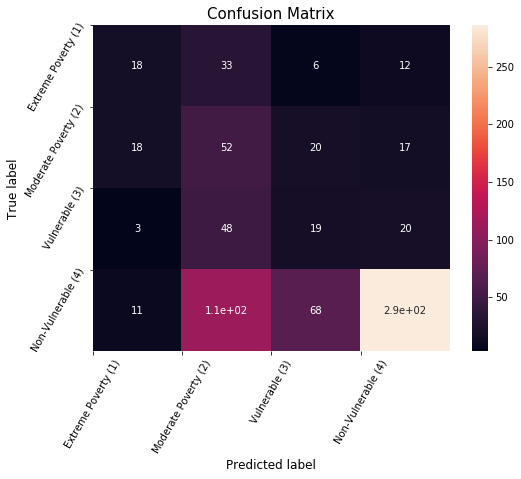

In [45]:
plot_confusion_matrix(y_test, gnb_pred)

## 6. Working with Imbalanced Data
<a id="imbdata"></a>

## 6.1 Weights
<a id="weights"></a>

In [58]:
weights = {1:2.5, 2:1, 3:1, 4:.5}
rf_weighted = RandomForestClassifier(n_estimators = 1600, min_samples_split = 4, max_features = 30, max_depth = 9,
                                     criterion = 'gini', class_weight = weights)
rf_weighted.fit(x_train, y_train)
rf_weighted_pred = rf_weighted.predict(x_test)
rf_weighted_report = classification_report(y_test, rf_weighted_pred)
print('----- ORIGINAL CLASSIFICATION REPORT -----\n')
print(rf_report)
print('----- WEIGHTED CLASSIFICATION REPORT -----\n')
print(rf_weighted_report)

----- ORIGINAL CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.64      0.10      0.18        69
           2       0.37      0.28      0.32       107
           3       0.21      0.03      0.06        90
           4       0.72      0.96      0.82       478

   micro avg       0.67      0.67      0.67       744
   macro avg       0.48      0.34      0.34       744
weighted avg       0.60      0.67      0.60       744

----- WEIGHTED CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.43      0.36      0.39        69
           2       0.40      0.32      0.35       107
           3       0.25      0.06      0.09        90
           4       0.77      0.93      0.84       478

   micro avg       0.68      0.68      0.68       744
   macro avg       0.46      0.42      0.42       744
weighted avg       0.62      0.68      0.64       744



## 6.2 Oversampling
<a id="smote"></a>

In [46]:
ros = RandomOverSampler(random_state=0)
x_resampled, y_resampled = ros.fit_resample(x_train, y_train)

([<matplotlib.axis.XTick at 0x1f407e542e8>,
 <a list of 4 Text xticklabel objects>)

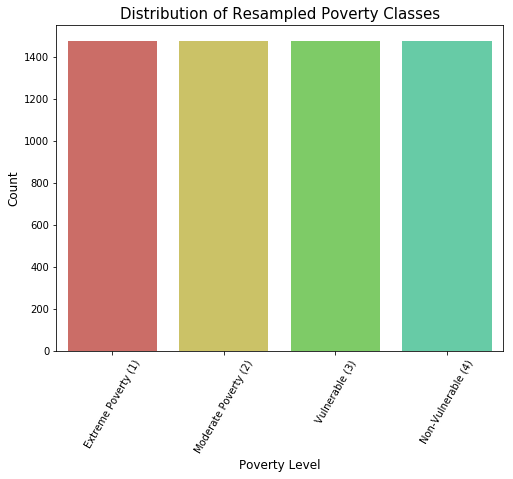

In [59]:
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(y_resampled)
plt.title('Distribution of Resampled Poverty Classes', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)

In [50]:
print('----- ORIGINAL CLASSIFICATION REPORT -----\n')
print(rf_report)
rf_resampled = RandomForestClassifier(n_estimators = 1600, min_samples_split = 4,
                                      max_features = 30, max_depth = 9, criterion = 'gini')
rf_resampled.fit(x_resampled, y_resampled)
rf_resampled_pred = rf_resampled.predict(x_test)
rf_resampled_report = classification_report(y_test, rf_resampled_pred)
print('----- RESAMPLING CLASSIFICATION REPORT -----\n')
print(rf_resampled_report)

----- ORIGINAL CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.64      0.10      0.18        69
           2       0.37      0.28      0.32       107
           3       0.21      0.03      0.06        90
           4       0.72      0.96      0.82       478

   micro avg       0.67      0.67      0.67       744
   macro avg       0.48      0.34      0.34       744
weighted avg       0.60      0.67      0.60       744

----- RESAMPLING CLASSIFICATION REPORT -----

              precision    recall  f1-score   support

           1       0.36      0.43      0.39        69
           2       0.29      0.37      0.33       107
           3       0.21      0.30      0.24        90
           4       0.88      0.72      0.79       478

   micro avg       0.59      0.59      0.59       744
   macro avg       0.43      0.46      0.44       744
weighted avg       0.66      0.59      0.62       744



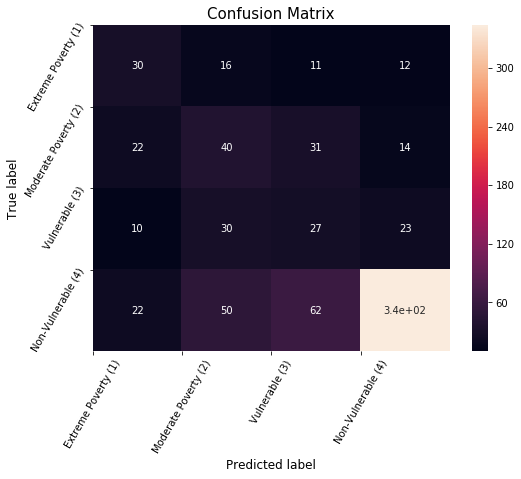

In [51]:
plot_confusion_matrix(y_test, rf_resampled_pred)

## 7. Understanding & Interpreting the Model
<a id="featimport"></a>

In [73]:
#Feature importances
feature_importances = pd.DataFrame(columns = ['Variable', 'Coef'])
feature_importances['Variable'] = list(x)
feature_importances['Coef'] = abs(rf_resampled.feature_importances_)
feature_importances.sort_values(by = 'Coef', ascending = False, inplace = True)
feature_importances = feature_importances[0:15]

Text(0.5, 1.0, 'Most Important Features in Resampled Random Forest Model')

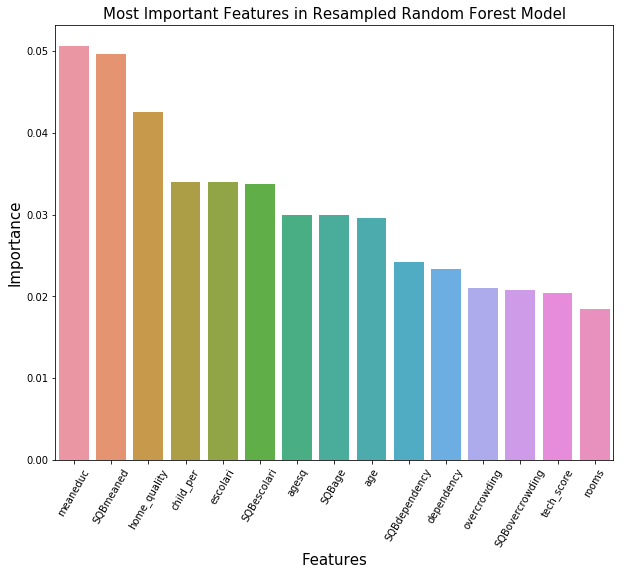

In [76]:
f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation='90')
sns.barplot(x=feature_importances['Variable'], y = feature_importances['Coef'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Importance', fontsize=15)
plt.xticks(rotation = 60)
plt.title('Most Important Features in Resampled Random Forest Model', fontsize=15)